In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
dynamic = pd.read_csv('./sph_dynamic.csv')
static = pd.read_csv('./sph_static.csv')

In [3]:
merge_df = pd.merge(dynamic, static, on = 'stay_id')

In [4]:
merge_df['icu_intime'] = pd.to_datetime(merge_df['icu_intime'], format = "%Y-%m-%d %H:%M:%S.%f")

for i in range(len(merge_df)):
        merge_df.loc[i, 'vent_start'] = pd.Timestamp(merge_df.loc[i, 'vent_start']).replace(year = merge_df.loc[i, 'icu_intime'].year)
        merge_df.loc[i, 'vent_end'] = pd.Timestamp(merge_df.loc[i, 'vent_end']).replace(year = merge_df.loc[i, 'icu_intime'].year)

merge_df['vent_start'] = pd.to_datetime(merge_df['vent_start'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['vent_end'] = pd.to_datetime(merge_df['vent_end'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['charttime'] = pd.to_datetime(merge_df['charttime'], format = "%Y-%m-%d %H:%M:%S.%f")

In [5]:
#Remove the chart data that is done after 12h in ICU
merge_df = merge_df[(merge_df['charttime'] - merge_df['icu_intime']).dt.total_seconds() <= 43200]  

#Remove the records of the patient that is intubated after 48h in ICU
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() <= 172800]

#Specific case: Last year of the day
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() >= 0]

In [6]:
#标准化，去除异常值
mean = np.mean(merge_df['vent_duration'])
std_dev = np.std(merge_df['vent_duration'])

merge_df['z_score'] = (merge_df['vent_duration'] - mean) / std_dev

merge_df = merge_df.loc[abs(merge_df['z_score']) <= 3]

In [7]:
#去除超过30天的数据
merge_df = merge_df.loc[(merge_df['icu_intime'] - merge_df['charttime']).apply(lambda x: x.total_seconds()) <= 31 * 60 * 60 * 60]

In [8]:
#去除缺失率高于40%的列
missing_percent = merge_df.isna().sum() / len(merge_df)

df = merge_df.drop(columns = missing_percent[missing_percent > 0.4].index)

In [9]:
df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score
17,34483718,2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
18,34483718,2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
19,34483718,2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
20,34483718,2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
21,34483718,2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,38307084,2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1,2153-12-19 02:35:00,2153-12-20 05:04:00,2153-12-21 06:00:00,24.933333,-0.270423
7020,39929091,2170-10-18 15:42:00,NaN,0.7,93.0,141.0,102.0,11.0,6.6,2170-10-18 15:21:13,2170-10-19 16:33:00,2170-10-20 00:00:00,7.450000,-0.573792
7021,37863848,2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8,2147-09-19 19:20:00,2147-09-20 19:00:00,2147-09-25 08:00:00,109.000000,1.188290
7022,33018891,2180-08-18 02:31:00,9.0,1.2,111.0,135.0,98.0,8.7,17.8,2180-08-18 00:52:00,2180-08-18 18:00:00,2180-08-19 12:00:00,18.000000,-0.390730


处理glucose异常值,去掉大于300的行

In [10]:
df = df.loc[df['glucose'] < 300]

In [11]:
df = df.reset_index(drop=True)

In [12]:
df.shape

(5325, 14)

In [13]:
# 用median策略插值
df = df.fillna(df.median())

C:\Users\Tcode9\AppData\Local\Temp\ipykernel_19712\2892663818.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.median())


In [14]:
#将icu_intime和vent_start相减作为新的feature
icu_intime = pd.to_datetime(df.iloc[:, -5])
vent_start = pd.to_datetime(df.iloc[:, -4])
time_diff = vent_start - icu_intime
# 将时间差转换为小时数，并将结果添加到 train_data 中
df['time_diff_hours'] = pd.to_timedelta(time_diff).dt.total_seconds() / 3600

In [15]:
df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score,time_diff_hours
0,34483718,2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
1,34483718,2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
2,34483718,2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
3,34483718,2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
4,34483718,2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1,2153-12-19 02:35:00,2153-12-20 05:04:00,2153-12-21 06:00:00,24.933333,-0.270423,26.483333
5321,39929091,2170-10-18 15:42:00,8.4,0.7,93.0,141.0,102.0,11.0,6.6,2170-10-18 15:21:13,2170-10-19 16:33:00,2170-10-20 00:00:00,7.450000,-0.573792,25.196389
5322,37863848,2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8,2147-09-19 19:20:00,2147-09-20 19:00:00,2147-09-25 08:00:00,109.000000,1.188290,23.666667
5323,33018891,2180-08-18 02:31:00,9.0,1.2,111.0,135.0,98.0,8.7,17.8,2180-08-18 00:52:00,2180-08-18 18:00:00,2180-08-19 12:00:00,18.000000,-0.390730,17.133333


In [16]:
df.to_csv('GrpAssignment_2_FinalPreprocess_data.csv', index=False)

In [17]:
num_stay_ids = df['stay_id'].nunique()
print('There are', num_stay_ids, 'unique stay_ids in the dataset.')

There are 1633 unique stay_ids in the dataset.


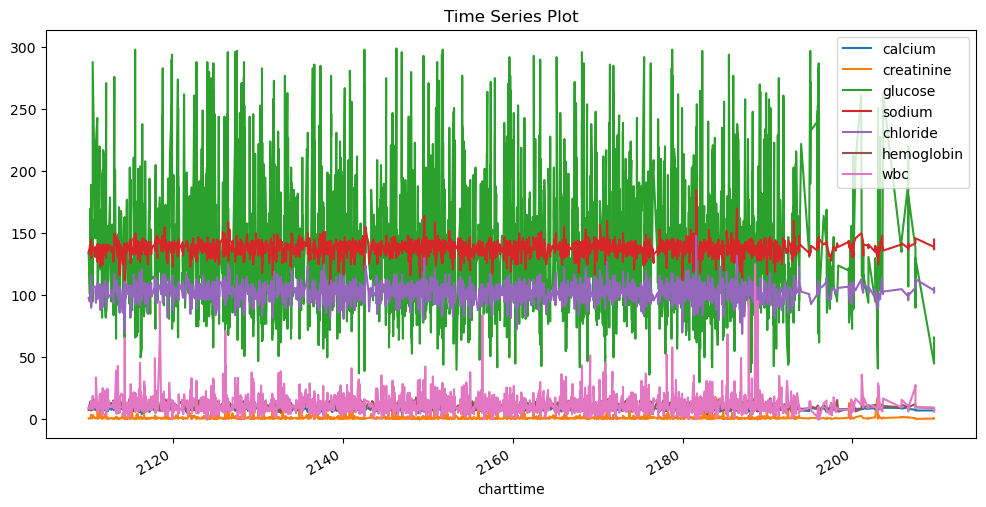

In [18]:
data = df.set_index('charttime')
data = data.iloc[:, 1: -6]
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax)
ax.set_title('Time Series Plot')
plt.show()

In [19]:
data

,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc
charttime,,,,,,,
2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3
2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0
2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3
2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3
2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9
...,...,...,...,...,...,...,...
2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1
2170-10-18 15:42:00,8.4,0.7,93.0,141.0,102.0,11.0,6.6
2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8


In [20]:
# data2 = data.drop('glucose', axis=1)
# fig, ax = plt.subplots(figsize=(12, 6))
# data2.plot(ax=ax)
# ax.set_title('Time Series Plot')
# plt.show()

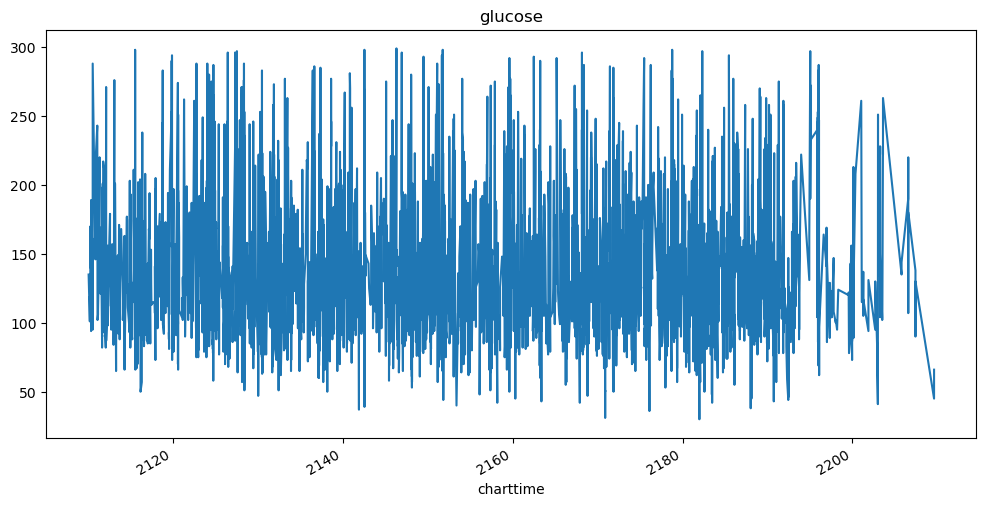

In [21]:
glucose_data = data['glucose']
fig, ax = plt.subplots(figsize=(12, 6))
glucose_data.plot(ax=ax)
ax.set_title('glucose')
plt.show()

可视化探索

In [22]:
# 按病人ID进行分组
#groups = df.groupby('stay_id')

In [23]:
data_AM = df.drop('z_score', axis=1)

In [24]:
data_AM

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,time_diff_hours
0,34483718,2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,13.120833
1,34483718,2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,13.120833
2,34483718,2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,13.120833
3,34483718,2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,13.120833
4,34483718,2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1,2153-12-19 02:35:00,2153-12-20 05:04:00,2153-12-21 06:00:00,24.933333,26.483333
5321,39929091,2170-10-18 15:42:00,8.4,0.7,93.0,141.0,102.0,11.0,6.6,2170-10-18 15:21:13,2170-10-19 16:33:00,2170-10-20 00:00:00,7.450000,25.196389
5322,37863848,2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8,2147-09-19 19:20:00,2147-09-20 19:00:00,2147-09-25 08:00:00,109.000000,23.666667
5323,33018891,2180-08-18 02:31:00,9.0,1.2,111.0,135.0,98.0,8.7,17.8,2180-08-18 00:52:00,2180-08-18 18:00:00,2180-08-19 12:00:00,18.000000,17.133333


对数据集进行标准化

In [25]:
#转化为timestamp
#data_AM['charttime'] =  data_AM['charttime'].apply(lambda x: x.timestamp())
data_AM['icu_intime'] = data_AM['icu_intime'].apply(lambda x: x.timestamp())
data_AM['vent_start'] = data_AM['vent_start'].apply(lambda x: x.timestamp())
data_AM['vent_end'] =   data_AM['vent_end'].apply(lambda x: x.timestamp())
charttime = data_AM['charttime']
data_AM = data_AM.drop('charttime', axis=1)

In [26]:
data_AM

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,time_diff_hours
0,34483718,8.2,0.8,129.0,141.0,101.0,8.7,11.3,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
1,34483718,8.3,0.6,110.0,140.0,104.0,8.0,5.0,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
2,34483718,8.6,0.8,73.0,142.0,108.0,8.4,6.3,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
3,34483718,8.0,0.9,140.0,136.0,102.0,8.2,7.3,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
4,34483718,8.3,0.9,137.0,138.0,98.0,8.1,10.9,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,10.1,0.9,140.0,136.0,99.0,15.7,7.1,5.805398e+09,5.805493e+09,5.805583e+09,24.933333,26.483333
5321,39929091,8.4,0.7,93.0,141.0,102.0,11.0,6.6,6.336545e+09,6.336636e+09,6.336662e+09,7.450000,25.196389
5322,37863848,8.5,1.0,104.0,141.0,102.0,11.4,13.8,5.608207e+09,5.608292e+09,5.608685e+09,109.000000,23.666667
5323,33018891,9.0,1.2,111.0,135.0,98.0,8.7,17.8,6.646842e+09,6.646903e+09,6.646968e+09,18.000000,17.133333


In [27]:
data_AM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          5325 non-null   int64  
 1   calcium          5325 non-null   float64
 2   creatinine       5325 non-null   float64
 3   glucose          5325 non-null   float64
 4   sodium           5325 non-null   float64
 5   chloride         5325 non-null   float64
 6   hemoglobin       5325 non-null   float64
 7   wbc              5325 non-null   float64
 8   icu_intime       5325 non-null   float64
 9   vent_start       5325 non-null   float64
 10  vent_end         5325 non-null   float64
 11  vent_duration    5325 non-null   float64
 12  time_diff_hours  5325 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 540.9 KB


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_AM.iloc[:,1:8] = pd.DataFrame(scaler.fit_transform(data_AM.iloc[:,1:8]), columns=data_AM.iloc[:,1:8].columns)

In [29]:
# data_AM['charttime'] = charttime
# data_AM = data_AM.set_index('charttime')

In [30]:
data_AM

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,time_diff_hours
0,34483718,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
1,34483718,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
2,34483718,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
3,34483718,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
4,34483718,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,4.670956e+09,4.671004e+09,4.671079e+09,21.000000,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,2.162153,-0.388665,0.173620,-0.262135,-0.448813,2.734854,-0.513026,5.805398e+09,5.805493e+09,5.805583e+09,24.933333,26.483333
5321,39929091,0.007664,-0.494757,-0.856361,0.637961,-0.001707,0.466173,-0.576972,6.336545e+09,6.336636e+09,6.336662e+09,7.450000,25.196389
5322,37863848,0.134398,-0.335619,-0.615301,0.637961,-0.001707,0.659252,0.343843,5.608207e+09,5.608292e+09,5.608685e+09,109.000000,23.666667
5323,33018891,0.768072,-0.229527,-0.461900,-0.442154,-0.597849,-0.644033,0.855406,6.646842e+09,6.646903e+09,6.646968e+09,18.000000,17.133333


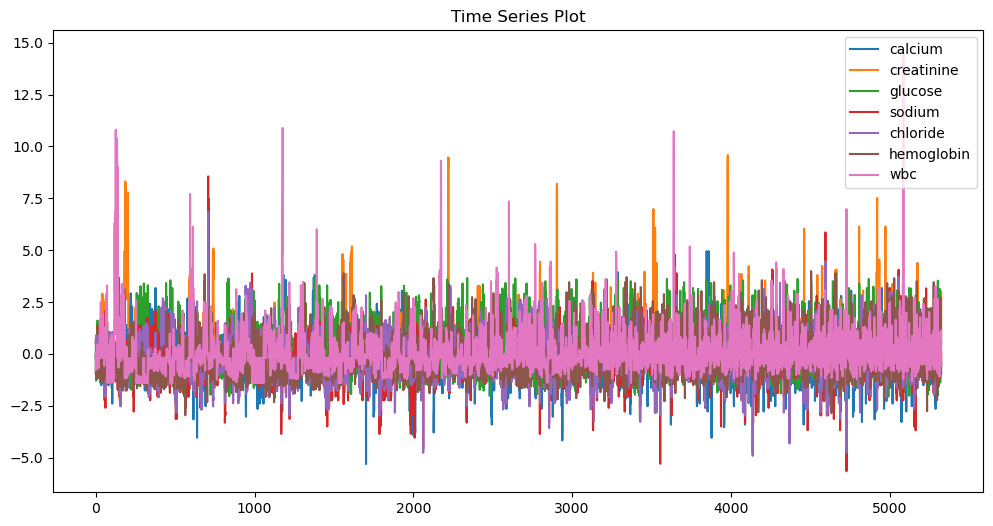

In [31]:
#data_s = df_scaled.set_index('charttime')
data_AM_show = data_AM.iloc[:, 1: 8]
#data_AM_show['vent_duration'] = data_AM['vent_duration']
fig, ax = plt.subplots(figsize=(12, 6))
data_AM_show.plot(ax=ax)
ax.set_title('Time Series Plot')
plt.show()

RandomForestRegressor

In [32]:
import statsmodels.api as sm

total_rows = len(df)
split_point = int(total_rows * 0.8)

# 获取80%分位数对应的stay_id
split_stay_id = data_AM.iloc[split_point]['stay_id']
print(total_rows,split_point,split_stay_id)
#分组
grouped = data_AM.groupby('stay_id')

# 找到该stay_id出现的最后一行
last_row_of_stay_100 = grouped.get_group(split_stay_id).tail(1)
# 获取80%分界的行号
boundary_index = last_row_of_stay_100.index[0]
print(boundary_index)
# 划分数据集
train_data = data_AM.iloc[:boundary_index, :]
test_data = data_AM.iloc[boundary_index:, :]

5325 4260 31458920.0
4262


In [33]:
train_data['charttime'] = charttime
train_data = train_data.set_index('charttime')
test_data['charttime'] = charttime
test_data = test_data.set_index('charttime')

C:\Users\Tcode9\AppData\Local\Temp\ipykernel_19712\3324388109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['charttime'] = charttime
C:\Users\Tcode9\AppData\Local\Temp\ipykernel_19712\3324388109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['charttime'] = charttime


In [34]:
train_data = train_data.drop('vent_end', axis=1)
test_data = test_data.drop('vent_end', axis=1)

In [35]:
train_data

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration,time_diff_hours
charttime,,,,,,,,,,,,
2118-01-04 03:58:00,34483718,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,4.670956e+09,4.671004e+09,21.000000,13.120833
2117-12-25 04:00:00,34483718,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,4.670956e+09,4.671004e+09,21.000000,13.120833
2117-12-20 15:20:00,34483718,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,4.670956e+09,4.671004e+09,21.000000,13.120833
2117-12-31 05:22:00,34483718,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,4.670956e+09,4.671004e+09,21.000000,13.120833
2118-01-05 04:59:00,34483718,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,4.670956e+09,4.671004e+09,21.000000,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...
2193-02-04 10:00:00,31458920,-0.626010,-0.070389,0.852970,2.258132,1.637682,-0.113065,-0.193299,7.040214e+09,7.040358e+09,36.116667,39.881667
2193-02-04 03:54:00,31458920,-1.006214,-0.123435,0.874884,3.338247,2.084788,0.707522,1.047242,7.040214e+09,7.040358e+09,36.116667,39.881667
2193-02-03 02:09:00,31458920,0.514602,-0.123435,0.436594,4.058323,1.786717,-0.113065,-0.193299,7.040214e+09,7.040358e+09,36.116667,39.881667


控制test集的范围

In [36]:
test_data = test_data[test_data['vent_duration'] <= 100]

In [37]:
test_data

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration,time_diff_hours
charttime,,,,,,,,,,,,
2193-02-03 06:41:00,31458920,0.261133,-0.123435,0.568081,2.978209,1.339611,1.479839,1.085610,7.040214e+09,7.040358e+09,36.116667,39.881667
2110-08-02 20:16:00,37460082,0.007664,-0.229527,0.173620,0.277922,0.296363,2.010807,-0.206088,4.436446e+09,4.436507e+09,7.000000,16.970000
2110-08-03 02:08:00,37460082,0.007664,-0.229527,-0.812532,0.277922,0.296363,2.155616,-0.359557,4.436446e+09,4.436507e+09,7.000000,16.970000
2185-05-23 05:04:00,35451559,0.007664,-0.388665,-0.198926,-0.262135,-0.597849,1.865997,-0.039830,6.797099e+09,6.797153e+09,11.833333,15.117778
2185-05-22 21:46:00,35451559,0.514602,-0.388665,-0.155097,-0.262135,-0.299778,2.059077,-0.154932,6.797099e+09,6.797153e+09,11.833333,15.117778
...,...,...,...,...,...,...,...,...,...,...,...,...
2143-11-08 08:27:00,35414722,0.007664,-0.547803,-0.527643,0.097903,-0.150743,1.238490,-0.602550,5.486252e+09,5.486420e+09,29.500000,46.533333
2153-12-18 22:50:00,38307084,2.162153,-0.388665,0.173620,-0.262135,-0.448813,2.734854,-0.513026,5.805398e+09,5.805493e+09,24.933333,26.483333
2170-10-18 15:42:00,39929091,0.007664,-0.494757,-0.856361,0.637961,-0.001707,0.466173,-0.576972,6.336545e+09,6.336636e+09,7.450000,25.196389


In [38]:
vent_duration = data_AM['vent_duration']
data_AM = data_AM.drop('vent_duration', axis=1)

In [39]:
x_train = train_data.iloc[:, 1:-2]
y_train = train_data.iloc[:, -2]
x_test = test_data.iloc[:, 1:-2]
y_test = test_data.iloc[:, -2]

In [40]:
x_train

,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start
charttime,,,,,,,,,
2118-01-04 03:58:00,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,4.670956e+09,4.671004e+09
2117-12-25 04:00:00,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,4.670956e+09,4.671004e+09
2117-12-20 15:20:00,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,4.670956e+09,4.671004e+09
2117-12-31 05:22:00,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,4.670956e+09,4.671004e+09
2118-01-05 04:59:00,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,4.670956e+09,4.671004e+09
...,...,...,...,...,...,...,...,...,...
2193-02-04 10:00:00,-0.626010,-0.070389,0.852970,2.258132,1.637682,-0.113065,-0.193299,7.040214e+09,7.040358e+09
2193-02-04 03:54:00,-1.006214,-0.123435,0.874884,3.338247,2.084788,0.707522,1.047242,7.040214e+09,7.040358e+09
2193-02-03 02:09:00,0.514602,-0.123435,0.436594,4.058323,1.786717,-0.113065,-0.193299,7.040214e+09,7.040358e+09


In [41]:
# # 绘制自相关图（ACF）和偏自相关图（PACF）
# fig, ax = plt.subplots(figsize=(10, 8))
# sm.graphics.tsa.plot_acf(x_train, lags=30, ax=ax)
# fig, ax = plt.subplots(figsize=(10, 8))
# sm.graphics.tsa.plot_pacf(x_train, lags=30, ax=ax)

In [42]:
# 相关系数矩阵
corr_matrix = train_data.corr()

<AxesSubplot:>

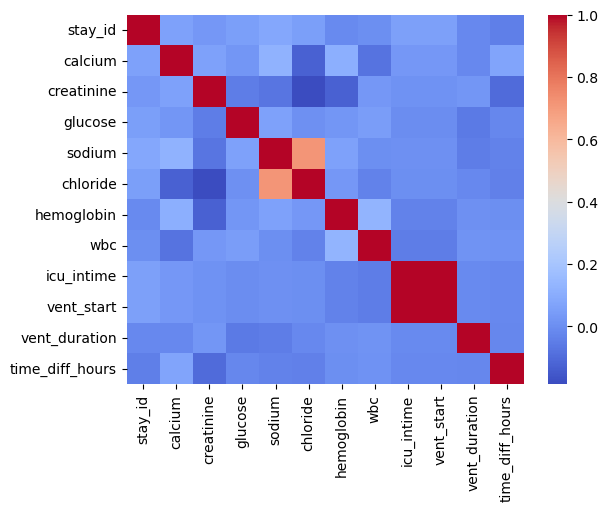

In [43]:
# 热力图
sns.heatmap(corr_matrix, cmap='coolwarm')

In [44]:
y_test

charttime
2193-02-03 06:41:00    36.116667
2110-08-02 20:16:00     7.000000
2110-08-03 02:08:00     7.000000
2185-05-23 05:04:00    11.833333
2185-05-22 21:46:00    11.833333
                         ...    
2143-11-08 08:27:00    29.500000
2153-12-18 22:50:00    24.933333
2170-10-18 15:42:00     7.450000
2180-08-18 02:31:00    18.000000
2115-03-31 04:55:00    46.000000
Name: vent_duration, Length: 986, dtype: float64

In [45]:
y_test.to_csv('y_test_data.csv', index=False)

In [46]:
# 训练随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [47]:
# 在测试集上进行预测
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = rf_model.predict(x_test)
# 计算模型评价指标
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
#print(f"R2 Score: {r2:.2f}")

MAE: 22.55
RMSE: 28.01


<function matplotlib.pyplot.show(close=None, block=None)>

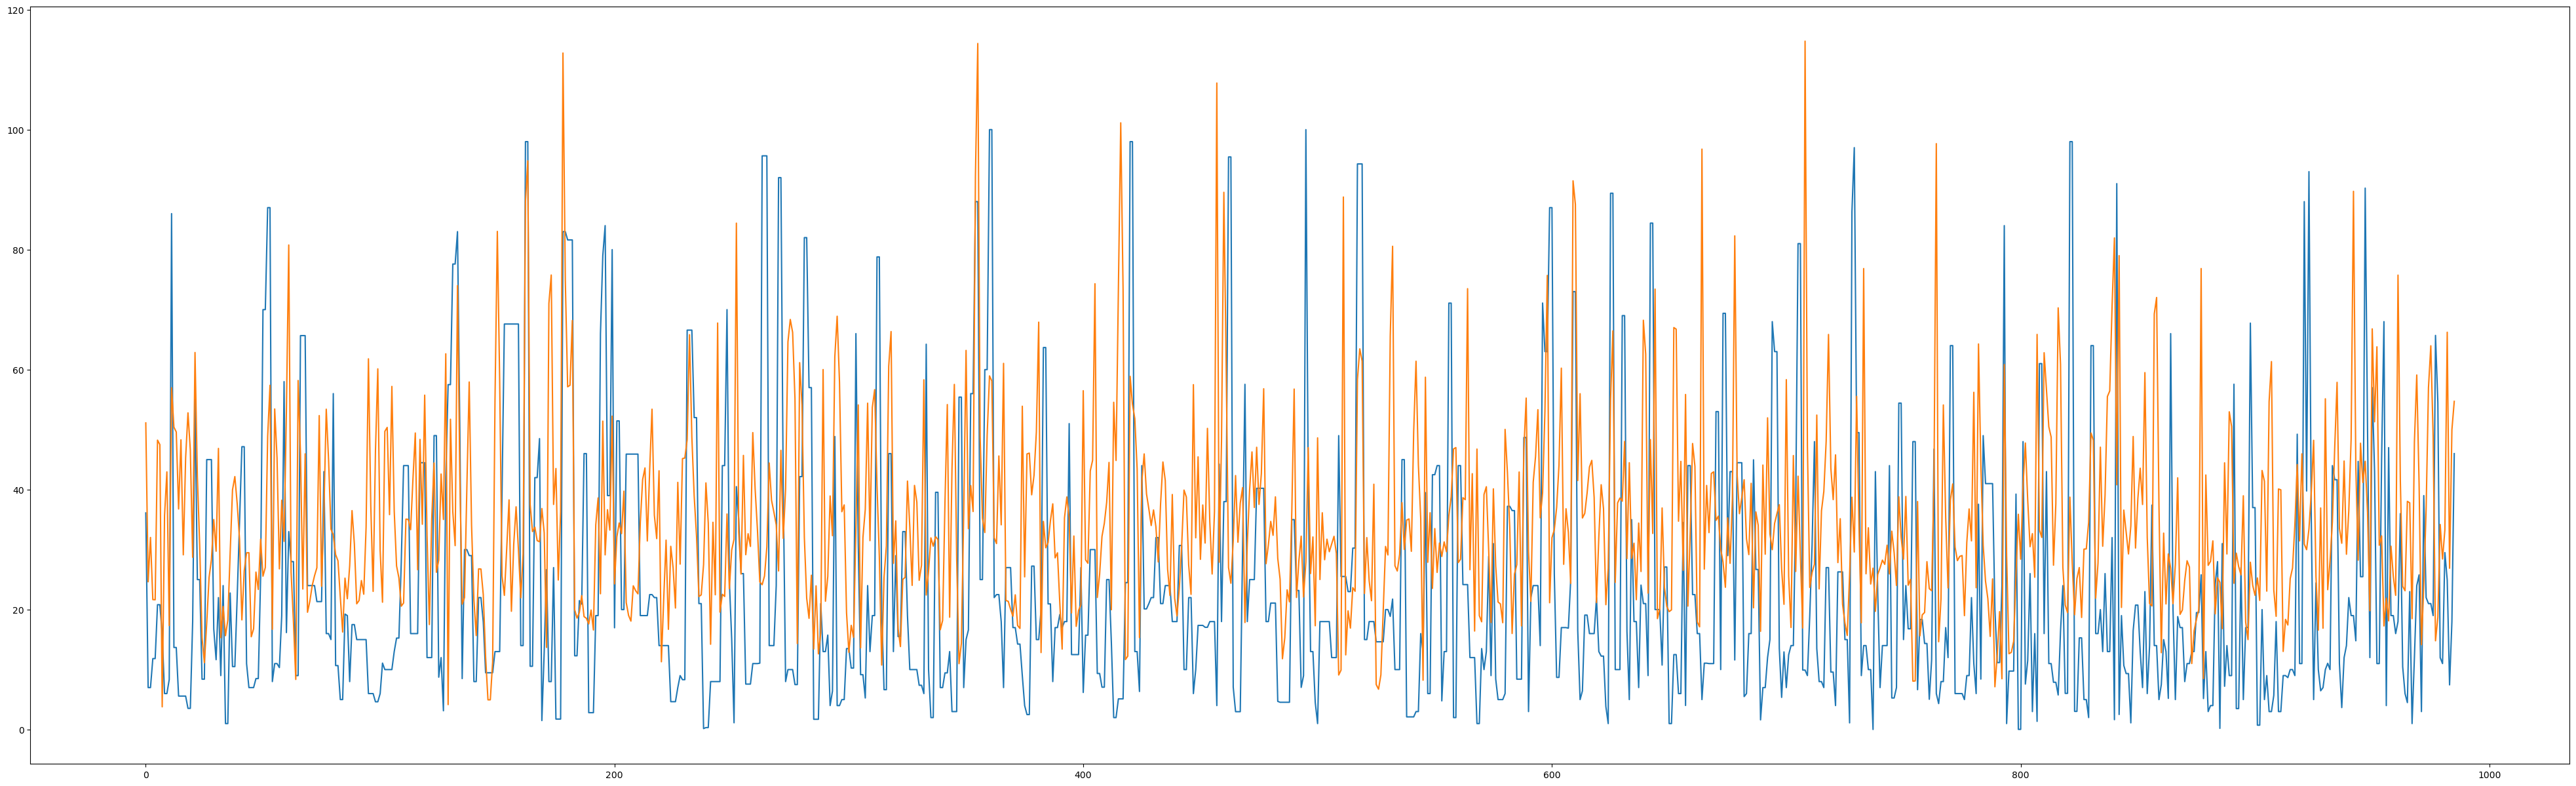

In [48]:
plt.figure(figsize = (50, 15))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.show

In [59]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer

rf_GS = RandomForestRegressor(random_state=42)

# 定义超参数空间
param_grid = {
    'n_estimators': [100, 200, 300, 500], 
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] 
}

# 定义评价指标
#mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(mean_squared_error, squared=False)
# 定义TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 定义GridSearchCV
grid_search = GridSearchCV(estimator=rf_GS, param_grid=param_grid, cv=tscv, scoring=rmse_scorer)

# 在训练集上进行网格搜索
grid_search.fit(x_train, y_train)

# 输出最佳参数和对应的得分
print('Best parameters: ', grid_search.best_params_)
print('Best CV score: ', grid_search.best_score_)

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score:  45.07068028141363


In [60]:
y_pred_CV = grid_search.predict(x_test)
mae = mean_absolute_error(y_test, y_pred_CV)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_CV))
r2 = r2_score(y_test, y_pred_CV)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 22.26
RMSE: 27.68
R2 Score: -0.48


<function matplotlib.pyplot.show(close=None, block=None)>

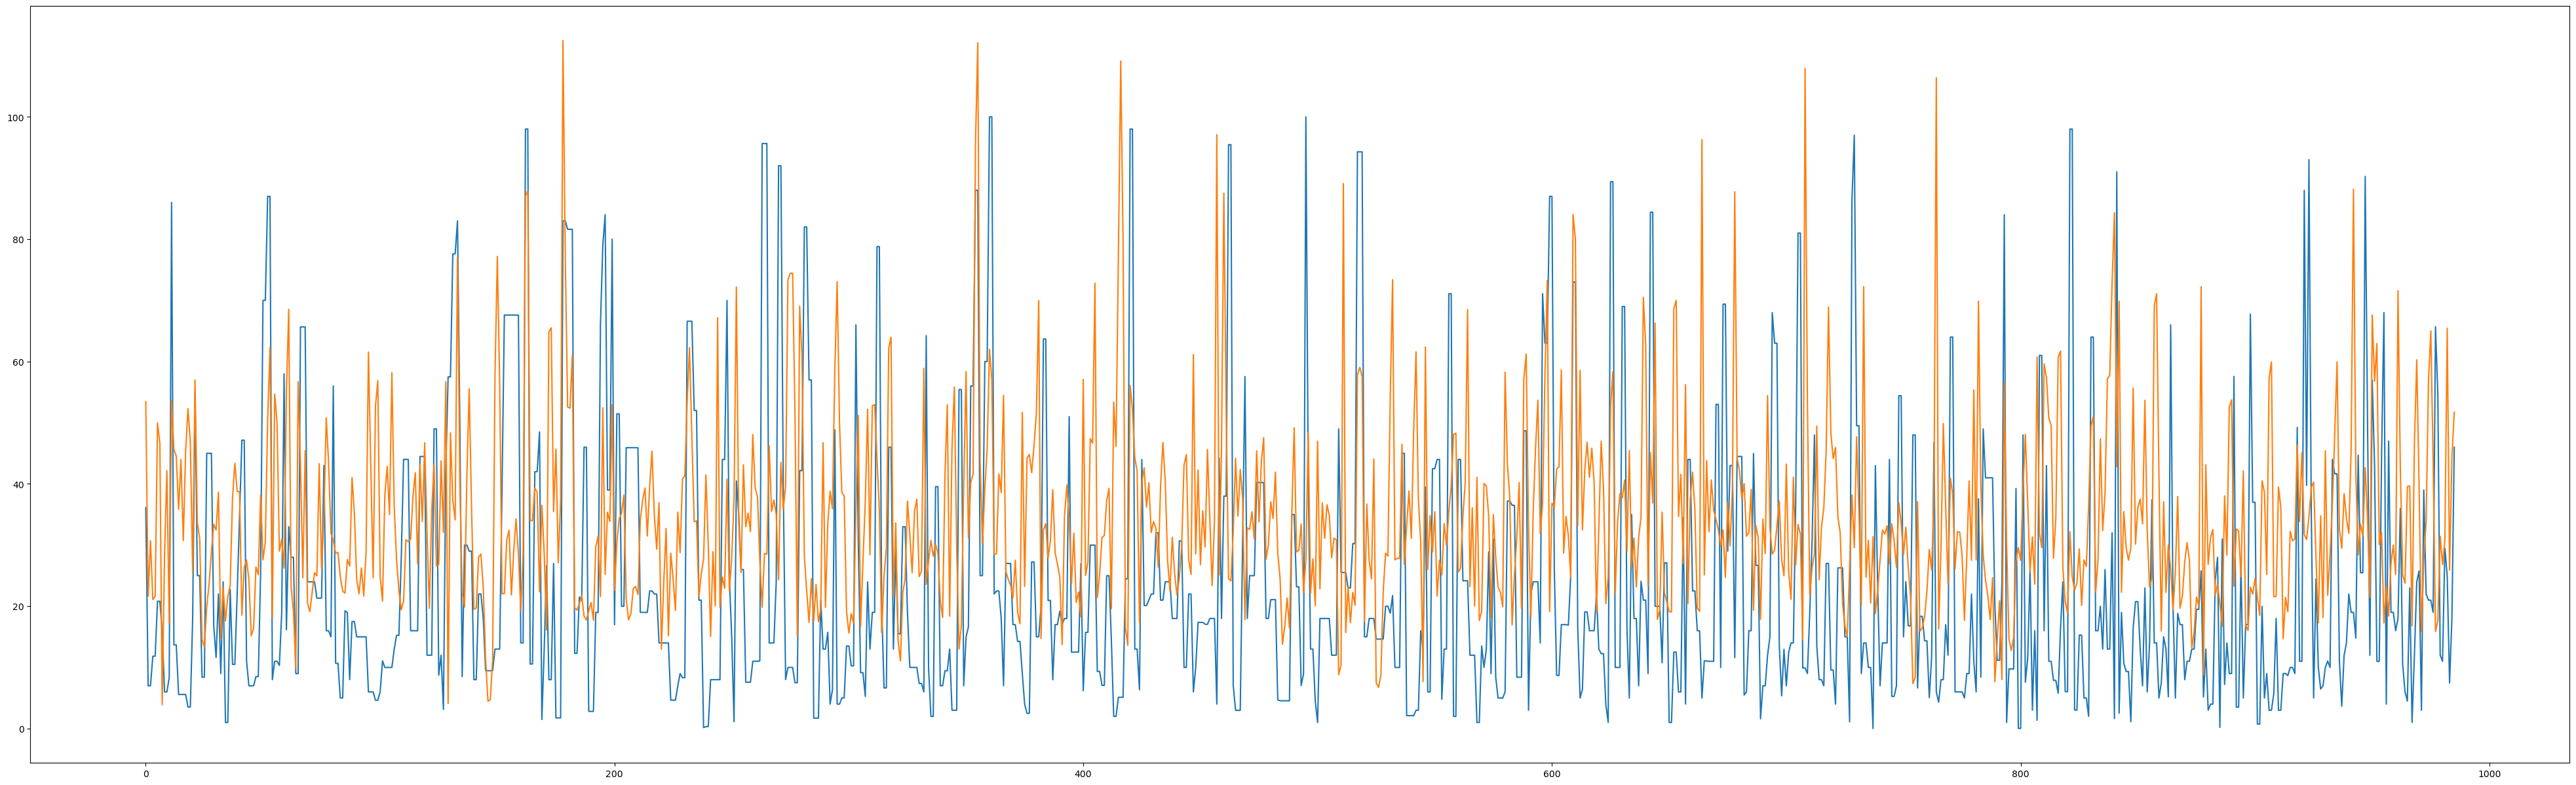

In [61]:
plt.figure(figsize = (50, 15))
plt.plot(y_test.values)
plt.plot(y_pred_CV)
plt.show

In [62]:
# Get best estimator from grid search object
best_rf = grid_search.best_estimator_

# Get feature importances
feature_importances = best_rf.feature_importances_
forest_importances = pd.Series(feature_importances, index=x_train.columns)

In [63]:
forest_importances

calcium       0.080762
creatinine    0.106499
glucose       0.049493
sodium        0.064942
chloride      0.073581
hemoglobin    0.106245
wbc           0.099791
icu_intime    0.212328
vent_start    0.206359
dtype: float64

In [ ]:
!pip install mapie
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn.pipeline import Pipeline

In [135]:
# alpha = 0.1
# mapie = MapieRegressor(
#     method="naive", agg_function="median", n_jobs=-1
# )
# mapie.fit(x_train, y_train)
# y_pred_p, y_pis = mapie.predict(x_test, alpha=alpha)
# coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
# width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

# # Plot estimated prediction intervals on test set
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)
# plt.ylabel("vent_duration (h)")
# ax.plot(y_test.values, lw=2, label="expected", c="C0")
# ax.plot(y_pred_p, lw=2, c="C1", label="Predictions")
# ax.fill_between(
#     y_pred_p,
#     y_pis[:, 0, 0],
#     y_pis[:, 1, 0],
#     color="C1",
#     alpha=0.1,
#     label="CV+ PIs",
# )
# ax.legend()
# plt.show()

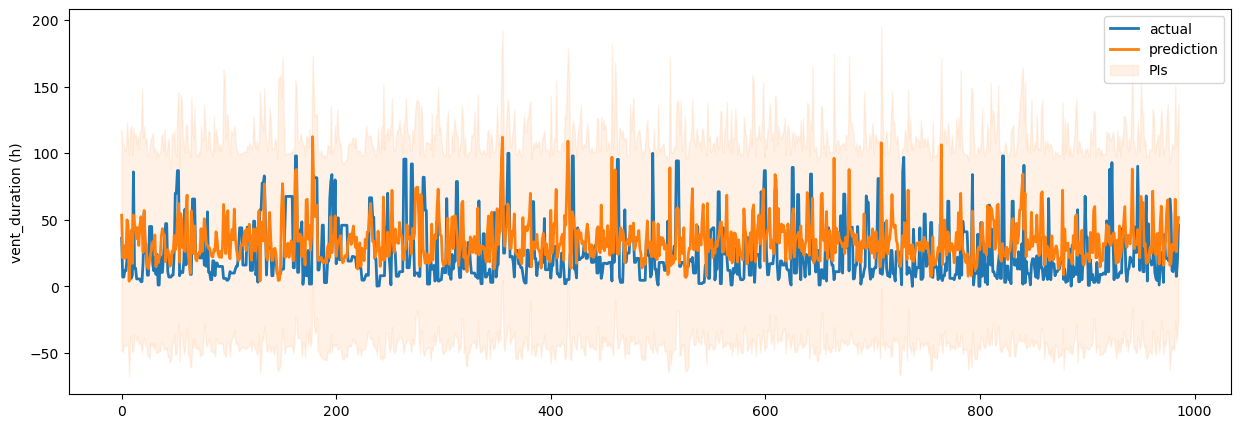

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from mapie.regression import MapieRegressor
import matplotlib.pyplot as plt

# 创建随机森林回归模型
rf = RandomForestRegressor(n_estimators=100, max_depth=10)

# 创建管道对象，将标准化和回归器包装在一起
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', rf)
])

# 使用管道对象创建MapieRegressor
mapie = MapieRegressor(pipe, method="minmax", n_jobs=-1)

# 拟合数据
mapie.fit(x_train, y_train)

# 预测测试集上的响应变量和预测区间
y_pred_p, y_pis = mapie.predict(x_test, alpha=0.1)
y_pred_p_df = pd.DataFrame(y_pred_p)
#y_pis_df = pd.DataFrame(y_pis)
# 计算覆盖率和平均宽度得分
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

# 绘制预测区间和实际值
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test.values,lw=2, label="actual", c="C0")
ax.plot(y_pred_CV, lw=2, c="C1", label="prediction")
ax.fill_between(
    #y_test.values,
    y_pred_p_df.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.1,
    label="PIs",
)
ax.legend()
plt.show()